# Exp: use Vanilla GAN(DCGAN) to generate QuickDraw with Keras

## Step1: load the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
data_path = './camel32/'
suffix = '.png'
data_length = 1000
x_train = None

for i in range(data_length):
    img = cv2.imread(data_path + str(i) + suffix)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = np.reshape(img,img.shape+(1,))
    img = np.expand_dims(img,axis=0)
    if x_train is None:
        x_train = img
    else:
        x_train = np.concatenate((x_train,img),axis=0)
print(x_train.shape)

(1000, 32, 32, 1)


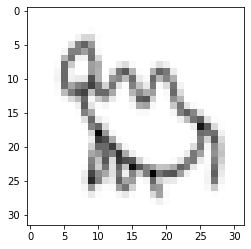

In [3]:
# show one of the camel's images
plt.imshow(x_train[0,:,:,:],cmap='gray')

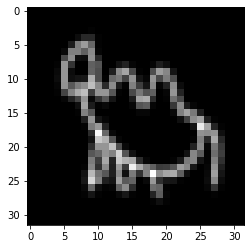

In [4]:
x_train = (255.0 - x_train.astype('float32'))
x_train = (x_train - 127.5)/127.5 # [0,255] => [-1,1]
plt.imshow((x_train[0,:,:,:]+1)/2,cmap='gray')

## Step2: define the GAN's model strucutre

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,Conv2DTranspose,Dropout,Reshape
from tensorflow.keras.layers import BatchNormalization,Activation,LeakyReLU,UpSampling2D,ZeroPadding2D
from tensorflow.keras import backend as K

z_dim = 100
generator_init_size = (8,8,64)
discriminator_learning_rate = 0.0004
generator_learning_rate = 0.0002
batch_size = 64
epochs = 500
epoch_rate = 1

In [19]:
class GAN():
    def __init__(self,z_dim,generator_init_size,discriminator_learning_rate,generator_learning_rate):
        self.z_dim = z_dim
        self.generator_init_size = generator_init_size
        self.discriminator_learning_rate = discriminator_learning_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.epoch_list = []
        self.d_losses = []
        self.g_losses = []
        
        self._build_model()
    def _build_model(self):
        # discriminator
        self._build_discriminator()
        # generator
        self._build_generator()
    def _compile_discriminator(self):
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(lr=self.discriminator_learning_rate, beta_1=0.5)
        # discriminator
        self.discriminator.compile(
            optimizer = optimizer,
            loss = 'binary_crossentropy', # target: 1 for true image, 0 for false image
            metrics = ['accuracy']
        )
    def _compile_generator(self):
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(lr=self.generator_learning_rate, beta_1=0.5)
        
        # frozen discriminator's weights when training generator
        self.discriminator.trainable =  False
        
        # generator
        model_input_layer = Input(shape=(self.z_dim,),name='model_input')
        model_output_layer = self.discriminator(self.generator(model_input_layer))
        self.generator_training_model = Model(model_input_layer,model_output_layer)
        
        self.generator_training_model.compile(
            optimizer = optimizer,
            loss = 'binary_crossentropy', # target: 1 for false image
            metrics = ['accuracy']
        )
        
    def fit_model(self,x_train,batch_size,epochs,epoch_rate):
        # compile discriminator
        self._compile_discriminator()
        
        ## train discriminator and generator in turns
        for epoch in range(epochs):
            # train discriminator
            d = self._fit_discriminator(x_train,batch_size)
            # train generator epoch_rate times at once => to make generator strong enough against discriminator
            # in case that the latter is too strong and the gradient would be vanished
            self._compile_generator()
            for _ in range(epoch_rate):
                g = self._fit_generator(batch_size)
            
            # log
            if epoch % (epochs//100) == 0:
                print(
                    "%d [D loss: %.3f] [D acc: %.3f] | [G loss: %.3f] [G acc: %.3f]"
                    % (epoch, d[0], d[3], g[0], g[1])
                )
            self.d_losses.append(d)
            self.g_losses.append(g)
    def _build_discriminator(self):
        # input layer
        self.discriminator_input_layer = Input(shape=(32,32,1),name = "discriminator_input")
        # conv layer 1 => (32,32,1) -> (16,16,32)
        x = Conv2D(
            filters = 32, kernel_size = 3,
            strides = 2, padding = 'same'
        )(self.discriminator_input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        # conv layer 2 => (16,16,32) -> (8,8,64)
        x = Conv2D(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'same'
        )(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        # conv layer 3 => (8,8,64) -> (4,4,128)
        x = Conv2D(
            filters = 128, kernel_size = 3,
            strides = 2, padding = 'same'
        )(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        # flatten layer
        x = Flatten()(x)
        # dense layer / output layer output range: [0,1] (prob to tell if input is authentic)
        self.discriminator_output_layer = Dense(
            units=1,activation='sigmoid',name='discriminator_output'
        )(x)
        
        self.discriminator = Model(self.discriminator_input_layer,self.discriminator_output_layer)
    def _build_generator(self):
        # input layer
        self.generator_input_layer = Input(shape=(self.z_dim,),name='generator_input')
        # dense layer => (z_dim,) -> (8,8,64)
        x = Dense(units=np.prod(self.generator_init_size))(self.generator_input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation('relu')(x)
        x = Reshape(target_shape=self.generator_init_size)(x)
        # up-sampling & conv layer 1(the similar effects with conv-T) => (8,8,64) -> (16,16,128)
        x = UpSampling2D()(x)
        x = Conv2D(
            filters = 128, kernel_size = 3,
            strides = 1, padding = 'same'
        )(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation('relu')(x)
        # up-sampling & conv layer 2 => (16,16,128) => (32,32,64)
        x = UpSampling2D()(x)
        x = Conv2D(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same'
        )(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Activation('relu')(x)
        # conv layer / output layer => (32,32,64) => (32,32,1)
        x = Conv2D(
            filters = 1, kernel_size = 3,
            strides = 1, padding = 'same',
            name = 'generator_output'
        )(x)
        self.generator_output_layer = Activation('tanh')(x) # image range: [-1,1]
        
        self.generator = Model(self.generator_input_layer,self.generator_output_layer)
    def _fit_discriminator(self,x_train,batch_size):
        # generate labels for supervising signals
        true_labels = np.ones(shape=(batch_size,1))
        fake_labels = np.zeros(shape=(batch_size,1))
        # train on true images from x_train
        true_idx = np.random.randint(0,x_train.shape[0],batch_size)
        true_imgs = x_train[true_idx]
        d_loss_true, d_acc_true = self.discriminator.train_on_batch(true_imgs,true_labels)
        # train on fake images from norm noise
        fake_noise = np.random.normal(0,1,(batch_size,self.z_dim))
        fake_imgs = self.generator.predict(fake_noise)
        d_loss_fake, d_acc_fake = self.discriminator.train_on_batch(fake_imgs,fake_labels)
        
        d_loss = 0.5 * (d_loss_true + d_loss_fake)
        d_acc = 0.5 * (d_acc_true + d_acc_fake)
        
        return [d_loss,d_loss_true,d_loss_fake, d_acc, d_acc_true, d_acc_fake]
    def _fit_generator(self,batch_size):
        # generate labels for supervising signals
        true_labels = np.ones(shape=(batch_size,1))
        # train on fake images from norm noise
        fake_noise = np.random.normal(0,1,(batch_size,self.z_dim))
        return self.generator_training_model.train_on_batch(fake_noise,true_labels)
    def discriminator_summary(self):
        self.discriminator.summary()
    def generator_summary(self):
        self.generator.summary()

## Step3: compile and train the model

In [20]:
gan = GAN(z_dim,generator_init_size,discriminator_learning_rate,generator_learning_rate)

In [21]:
gan.discriminator_summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 64)          0   

In [22]:
gan.generator_summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              413696    
_________________________________________________________________
batch_normalization_22 (Batc (None, 4096)              16384     
_________________________________________________________________
activation_12 (Activation)   (None, 4096)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)       7385

In [23]:
gan.fit_model(x_train,batch_size,epochs,epoch_rate)

0 [D loss: 0.862] [D acc: 0.461] | [G loss: 0.718] [G acc: 0.188]
5 [D loss: 0.113] [D acc: 1.000] | [G loss: 1.775] [G acc: 0.016]
10 [D loss: 0.062] [D acc: 1.000] | [G loss: 3.505] [G acc: 0.000]
15 [D loss: 0.052] [D acc: 1.000] | [G loss: 4.096] [G acc: 0.031]
20 [D loss: 0.055] [D acc: 1.000] | [G loss: 4.990] [G acc: 0.000]
25 [D loss: 0.040] [D acc: 1.000] | [G loss: 4.323] [G acc: 0.000]
30 [D loss: 0.026] [D acc: 1.000] | [G loss: 3.383] [G acc: 0.016]
35 [D loss: 0.023] [D acc: 1.000] | [G loss: 2.571] [G acc: 0.000]
40 [D loss: 0.034] [D acc: 1.000] | [G loss: 2.395] [G acc: 0.000]
45 [D loss: 0.086] [D acc: 1.000] | [G loss: 3.204] [G acc: 0.000]
50 [D loss: 0.049] [D acc: 1.000] | [G loss: 2.819] [G acc: 0.016]
55 [D loss: 0.050] [D acc: 1.000] | [G loss: 1.994] [G acc: 0.000]
60 [D loss: 0.047] [D acc: 1.000] | [G loss: 1.755] [G acc: 0.000]
65 [D loss: 0.073] [D acc: 1.000] | [G loss: 2.601] [G acc: 0.000]
70 [D loss: 0.337] [D acc: 0.875] | [G loss: 2.036] [G acc: 0.01

## Step4: show the loss and accuracy curve

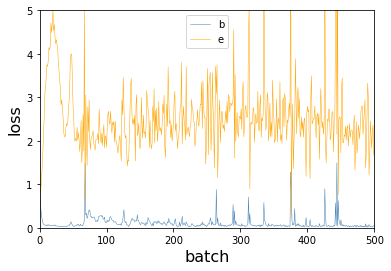

In [24]:
import matplotlib.pyplot as plt

# draw loss curve
fig = plt.figure()

plt.plot([x[0] for x in gan.d_losses], color='steelblue', linewidth=0.5,label='d_avg_loss')
# plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25,label='d_true_loss')
# plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25,label='d_fake_loss')
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.5,label='g_loss')

plt.xlabel('batch', fontsize=16)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, epochs)
plt.ylim(0, 5)

plt.legend('best')

plt.show()

$\Rightarrow \mathrm{Loss}\;\mathrm{Shock}$

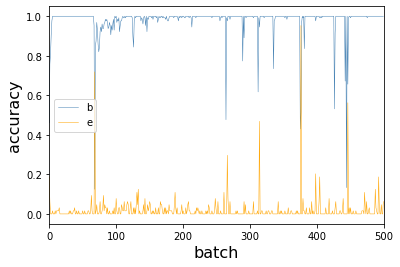

In [25]:
# draw accuracy curve
fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='steelblue', linewidth=0.5,label='d_avg_acc')
# plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25,label='d_true_acc')
# plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25,label='d_fake_acc')
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.5,label='g_acc')

plt.xlabel('batch', fontsize=16)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, epochs)

plt.legend('best')

plt.show()

## Step5: show the generation effect

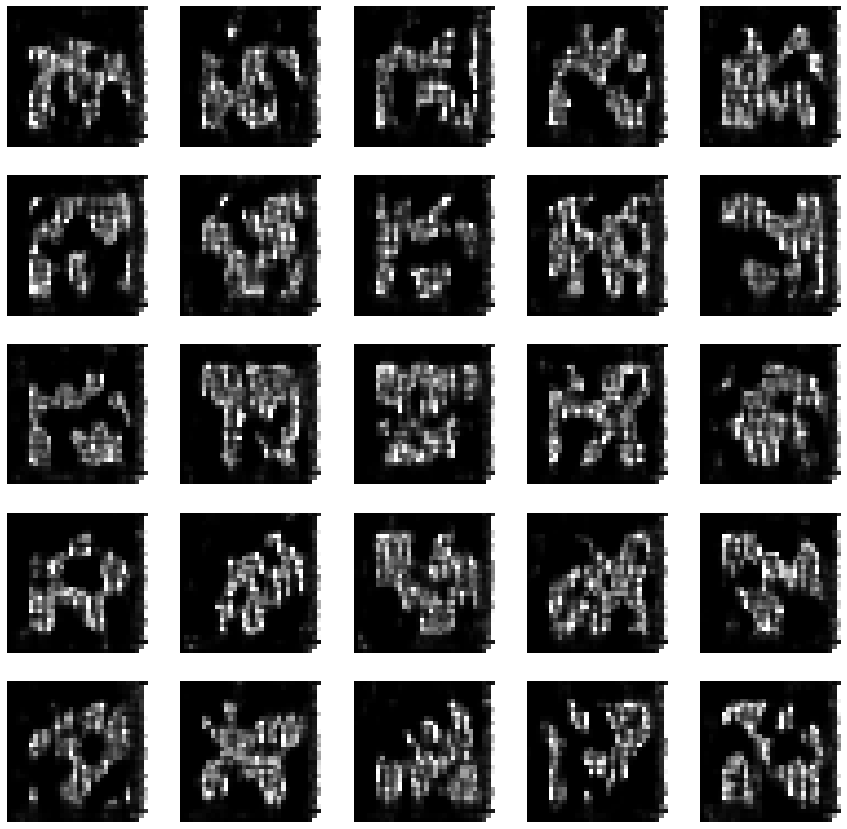

In [53]:
## new generated images by generator
r,c = 5,5
noise = np.random.normal(0, 1, (r * c, gan.z_dim))
gen_imgs = gan.generator.predict(noise)

#Rescale images 0 - 1

gen_imgs = 1.5 * (gen_imgs + 1)
gen_imgs = np.clip(gen_imgs, 0, 1)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,:],cmap = 'gray')
        axs[i,j].axis('off')
        cnt += 1

plt.show()
plt.close()

$\Rightarrow \mathrm{Model}\; \mathrm{Collapse}\; \mathrm{Problem}$

## Step6: find the closest image for the generation

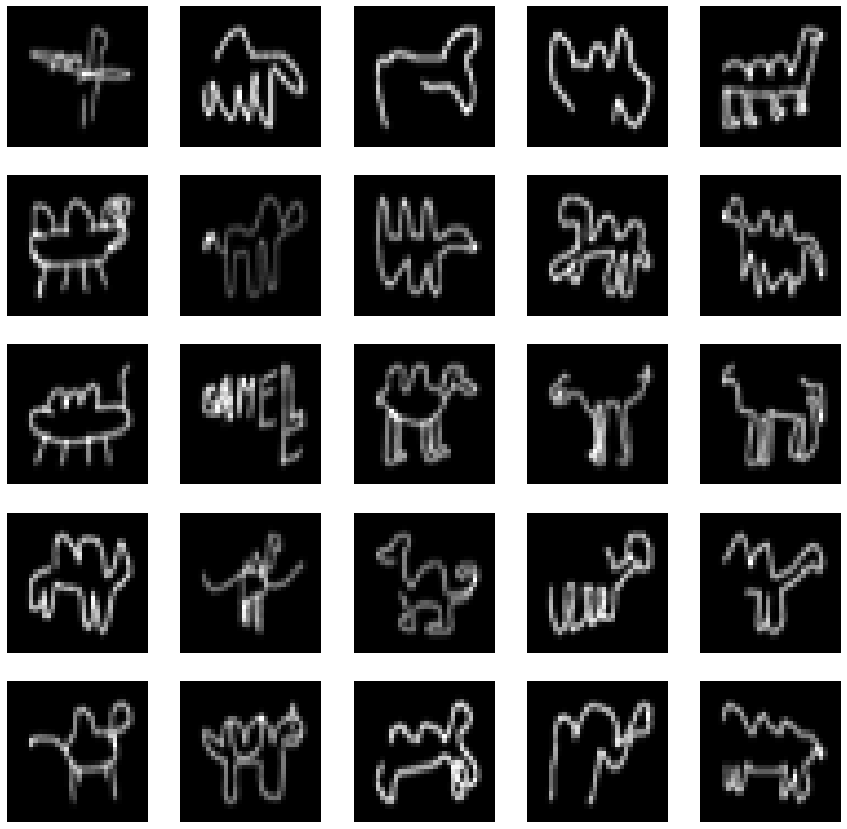

In [54]:
fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

def l1_mean_distance(img1, img2):
    return np.mean(np.abs(img1 - img2))

for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate((x_train + 1) * 0.5):
            
            diff = l1_mean_distance(gen_imgs[cnt, :,:,:], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i,j].imshow(c_img, cmap = 'gray')
        axs[i,j].axis('off')
        cnt += 1

plt.show()
plt.close()